In [1]:
import os
import geopandas as gpd
import re
import numpy as np
import rioxarray as rxr
import rasterio as rio
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from osgeo import gdal, osr; gdal.UseExceptions()
import shutil
from IPython import display
from time import sleep
import pandas as pd
from statistics import stdev
import cv2
from datetime import datetime
import psutil
from rioxarray.merge import merge_arrays

In [ ]:
#configure logging to file
import logging
log_path = f"data/output/logs/calibration_{datetime.now().strftime('%d%m%Y%H%M%S')}.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path,level=logging.INFO, format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.handlers.clear()
logger.addHandler(logging.StreamHandler())
logger.info("Starting procedure")

Starting procedure


In [ ]:
min_intersection_area = 150 #sq meters
orb_features = 2000
min_matches = 4
matches_dist_coef = 0.65
padding = 100
checkpoint = False

logger.info(f"Config:: min_intersection_area: {min_intersection_area}, orb_features: {orb_features}, min_matches: {min_matches}, matches_dist_coef: {matches_dist_coef}, checkpoint: {checkpoint}")

Config:: min_intersection_area: 150, orb_features: 2000, min_matches: 4, matches_dist_coef: 0.65, checkpoint: True


In [ ]:
tmp_dir = "tmp"
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
os.mkdir(tmp_dir)
tiff_dir = "data/output/tiff"
assert os.path.exists(tiff_dir), "tiff_dir does not exist. Please run 1_conversion.ipynb first."
geotiff_dir = "data/output/geotiff"
assert os.path.exists(geotiff_dir), "geotiff_dir does not exist. Please run 1_conversion.ipynb first."
footprints_path = "data/output/footprints.geojson"
assert os.path.exists(footprints_path), "footprints.geojson does not exist. Please run 1_conversion.ipynb first."
mosaic_path = "data/output/mosaic.tiff"
assert os.path.exists(mosaic_path), "mosaic.tif does not exist. Please run 1_conversion.ipynb first."
mosaic_cal_path = "data/output/mosaic_cal.tiff"
tiff_cal_dir = "data/output/tiff_cal"
geotiff_cal_dir = "data/output/geotiff_cal"
checkpoint_path = "data/output/checkpoint.pkl"
if checkpoint: assert os.path.exists(checkpoint_path), "checkpoint file does not exist"


In [ ]:
class MatchFailedError(Exception):
    pass

def nan_padding(arr, width):
    arr[0:width, :] = np.nan
    arr[-width:, :] = np.nan
    arr[:, 0:width] = np.nan
    arr[:, -width:] = np.nan
    return arr

def get_common_parts(src_arr, dst_arr):
    """ Get common parts of two arrays using image stitching (https://github.com/sachin-vs/UAV-Image-stitching) """
    src_arr_norm = cv2.normalize(src_arr, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    dst_arr_norm = cv2.normalize(dst_arr, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    orb = cv2.SIFT_create()#(nfeatures=orb_features)
    src_keypoints, src_descriptors = orb.detectAndCompute(src_arr_norm, None)
    dst_keypoints, dst_descriptors = orb.detectAndCompute(dst_arr_norm, None)
    bf = cv2.BFMatcher()#cv2.BFMatcher_create(cv2.NORM_HAMMING)
    matches = bf.knnMatch(src_descriptors, dst_descriptors,k=2)
    matches = [m for m, n in matches if m.distance < matches_dist_coef * n.distance]
    if len(matches) < min_matches:
        raise MatchFailedError(f"Not enough matches ({len(matches)} < {min_matches})")
    src_pts = np.float32([ src_keypoints[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([ dst_keypoints[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    if H is None:
        raise MatchFailedError(f"Homography is None")
    src_rows, src_cols = src_arr.shape[:2]
    dst_rows, dst_cols = dst_arr.shape[:2]

    src_points = np.float32([[0,0], [0,src_rows], [src_cols,src_rows], [src_cols,0]]).reshape(-1,1,2)

    src_points = cv2.perspectiveTransform(src_points, H)
    dst_points = np.float32([[0,0], [0, dst_rows],[dst_cols, dst_rows], [dst_cols, 0]]).reshape(-1, 1, 2)

    list_of_points = np.concatenate((src_points, dst_points), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    logger.info(f"Offsets: ({x_min}, {y_min}, {x_max}, {y_max})")
    if abs(x_min) > 2*max(src_cols, dst_cols) or abs(y_min) > 2*max(src_rows, dst_rows) or abs(x_max) > 2*max(src_cols, dst_cols) or abs(y_max) > 2*max(src_rows, dst_rows):
        raise MatchFailedError(f"Too big offset ({x_min}, {y_min}, {x_max}, {y_max})")
    translation_dist = [-x_min,-y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    
    src_arr = nan_padding(src_arr, padding)
    dst_arr = nan_padding(dst_arr, padding)
    src_common = cv2.warpPerspective(src_arr, H_translation.dot(H), (x_max-x_min, y_max-y_min), borderValue=np.nan)

    src_mask = np.isnan(src_common)
    
    dst_common = np.empty(src_common.shape, np.float32)
    dst_common[:] = np.nan
    dst_common[translation_dist[1]:dst_rows+translation_dist[1], translation_dist[0]:dst_cols+translation_dist[0]] = dst_arr
    dst_mask = np.isnan(dst_common)
    
    mask = src_mask | dst_mask
    dst_common[mask] = np.nan
    src_common[mask] = np.nan
    #count not nan values in src_common and dst_common
    src_common_count = np.count_nonzero(~np.isnan(src_common))
    dst_common_count = np.count_nonzero(~np.isnan(dst_common))
    if src_common_count == 0 or dst_common_count == 0:
        raise MatchFailedError(f"Empty common part (src_common_count={src_common_count}, dst_common_count={dst_common_count})")
    del src_mask, dst_mask, mask, src_arr, dst_arr, src_arr_norm, dst_arr_norm, src_keypoints, src_descriptors, dst_keypoints, dst_descriptors, matches, src_pts, dst_pts, H, src_rows, src_cols, dst_rows, dst_cols, src_points, dst_points, list_of_points, x_min, y_min, x_max, y_max, translation_dist, H_translation
    return src_common, dst_common
    
def get_offset(src_arr, dst_arr):
    diff =(src_arr-dst_arr)
    mean = np.nanmean(diff)
    std = np.nanstd(diff.flatten())
    return mean, 1./std

0.7699978869734576


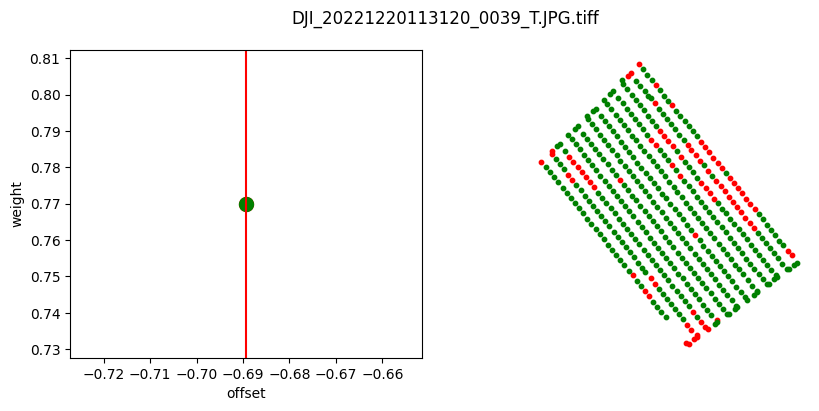

/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
Calibrated:: offset: -0.6892942786216735, weight: 0.7699978869734576, std: 0.0
Memory: 680.66 MB
Saving checkpoint
 96%|█████████▌| 449/468 [02:19<00:04,  4.01it/s]DJI_20221220112004_0237_T.JPG.tiff already calibrated, skipping
/usr/local/lib/python3.9/dist-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore

Calibrating:: dst: DJI_20221220111212_0079_T.JPG.tiff
Matching:: src: DJI_20221220111217_0080_T.JPG.tiff
Match failed:: Not enough matches (2 < 4), intersection: 284.24149481791557
Matching:: src: DJI_20221220111

In [ ]:
if checkpoint:
    logger.info("Loading checkpoint")
    with open(checkpoint_path, "rb") as f:
        (id_dists, footprints) = pickle.load(f)
    #get list of calibrated footprints
    calibrated_names = footprints[footprints["calibrated"]==True]["name"]
    #assert that all calibrated footprints exist in the tiff_cal_dir
    for name in calibrated_names:
        assert os.path.exists(os.path.join(tiff_cal_dir, name)), f"Photos in {tiff_cal_dir} dosn't match calibrated photos from checkpoint"
else:
    logger.info("Starting from scratch")
    logger.info(f"Clearing {tiff_cal_dir}")
    if os.path.exists(tiff_cal_dir):
        shutil.rmtree(tiff_cal_dir)
    os.makedirs(tiff_cal_dir)
    logger.info("Detecting intersections")
    footprints = gpd.read_file(footprints_path)
    inters = []
    for id_i, row_i in tqdm(footprints.iterrows()):
        inter = []
        for id_j, row_j in footprints.iterrows():
            if id_i == id_j:
                continue
            padding_m = row_i["pixel_size"]*padding
            if row_i['geometry'].buffer(-padding_m).intersects(row_j['geometry'].buffer(-padding_m)):
                area = row_i['geometry'].buffer(-padding_m).intersection(row_j['geometry'].buffer(-padding_m)).area
                inter.append({"id": id_j,"area": area})
        inter = sorted(inter, key=lambda k: k['area'], reverse=True)
        inters.append(inter)
    footprints['intersect'] = inters

    logger.info("Initializing columns")
    footprints['std']=None
    footprints['weight']=None
    footprints['offset']=None
    footprints['calibrated']=False

    logger.info("Setting reference point and refrence photo")
    name = "DJI_20221220111743_0190_T.JPG.tiff"
    offset = 2.0-4.8
    raster = rxr.open_rasterio(os.path.join(tiff_dir, name))
    raster.values = raster.values + offset
    raster.rio.to_raster(os.path.join(tiff_cal_dir, name))
    footprints.loc[footprints['name'] == name, 'offset'] = offset
    footprints.loc[footprints['name'] == name, 'calibrated'] = True
    footprints.loc[footprints['name'] == name, 'std'] = 0.0
    footprints.loc[footprints['name'] == name, 'weight'] = None
    centroid = footprints.loc[footprints['name'] == name, 'geometry'].centroid.values[0]
    ref_points = gpd.GeoDataFrame(geometry=[centroid], data={'temperature': [8.0]}, crs='EPSG:32634')

    logger.info("Setting the calibration order")
    id_dists = []
    for id_i, row_i in tqdm(footprints.iterrows()):
        dists = []
        for point in ref_points['geometry']:
            dists.append(row_i['geometry'].centroid.distance(point))
        dist = min(dists)
        if not row_i['calibrated']:
            id_dists.append({"id": id_i, "dist": dist})
    id_dists = sorted(id_dists, key=lambda k: k['dist'])
    
    logger.info("Saving checkpoint")
    pickle.dump((id_dists, footprints), open(checkpoint_path, "wb"))
    
logger.info("Calibrating pairs")
for id_dist in tqdm(id_dists):
    dst_id = id_dist['id']
    dst = footprints.iloc[dst_id]
    if dst['calibrated']:
        logger.info(f"{dst['name']} already calibrated, skipping")
        continue
    dst_raster = rxr.open_rasterio(f"{tiff_dir}/{dst['name']}", masked=True)
    offsets = []
    weights = []
    logger.info(f"")

    logger.info(f"Calibrating:: dst: {dst['name']}")
    for inter in footprints.iloc[dst_id]['intersect']:
        if footprints.iloc[inter['id']]['calibrated']:
            src_id = inter['id']
            src = footprints.iloc[src_id]
            src_raster = rxr.open_rasterio(f"{tiff_cal_dir}/{src['name']}", masked=True)#.rio.clip([dst['geometry']])
            logger.info(f"Matching:: src: {src['name']}")
            try:
                src_clip, dst_clip = get_common_parts(src_raster[0].values, dst_raster[0].values)
            except MatchFailedError as e:
                logger.info(f"Match failed:: {e}, intersection: {inter['area']}")
                continue
            offset, weight = get_offset(src_clip, dst_clip)
            logger.info(f"Match succeed:: offset: {offset}, weight: {weight}, intersection: {inter['area']}")
            offsets.append(offset)
            weights.append(weight)
    if len(offsets) > 0:
        offsets = np.array(offsets)
        weights = np.array(weights)
        offsets_all = offsets.copy()
        weights_all = weights.copy()
        if len(offsets) > 1:
            indices = np.abs(offsets - np.mean(offsets)) < 2*np.std(offsets) #remove outliers
            offsets = offsets[indices]
            weights = weights[indices]
        weight = weights.mean()
        offset = (offsets*weights).sum()/weights.sum()

        #Display
        display.clear_output(wait=True)
        print(weight)
        #create two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
        # set figure title
        fig.suptitle(f"{dst['name']}")
        #plot offsets against weights
        ax1.scatter(offsets_all, weights_all, s=100, color='red')
        ax1.scatter(offsets, weights, s=100, color='green')
        ax1.set_xlabel('offset')
        ax1.set_ylabel('weight')
        ax1.axvline(offset, color='r')
        # plot points
        #plot footprints centroids where calibrated=False
        footprints[footprints['calibrated']==False].centroid.plot(ax=ax2, color='red', markersize=10)
        #plot footprints centroids where calibrated=True
        footprints[footprints['calibrated']==True].centroid.plot(ax=ax2, color='green', markersize=10)
        #hide axis
        ax2.axis('off')
        plt.show()

        std = np.std(offsets) if len(offsets) > 1 else 0.0
        footprints.loc[dst_id, 'std'] = std
        footprints.loc[dst_id, 'weight'] = weight
        footprints.loc[dst_id, 'offset'] = offset
        footprints.loc[dst_id, 'calibrated'] = True
        
        dst_raster.values = (dst_raster.values+offset)
        dst_raster.rio.to_raster(f"{tiff_cal_dir}/{dst['name']}")
        logger.info(f"Calibrated:: offset: {offset}, weight: {weight}, std: {footprints.loc[dst_id, 'std']}")
        logger.info(f"Memory: {psutil.Process(os.getpid()).memory_info().rss/1024**2:.2f} MB")
        logger.info("Saving checkpoint")
    else:
        logger.info(f"Calibration failed:: no matches found")
    pickle.dump((id_dists, footprints), open(checkpoint_path, "wb"))

In [ ]:
from rioxarray.merge import merge_arrays

In [ ]:
os.makedirs(geotiff_cal_dir, exist_ok=True)
calibration = footprints[["name", "offset", "std", "weight", "calibrated"]]
calibration.to_csv("data/output/calibration.csv", index=False)
rasters = []
for row in calibration.itertuples():
    if row.calibrated == False:
        logger.info(f"Skipping not calibrated image:: {row.name}")
        continue
    logger.info(f"Generating calibrated GeoTIFF:: {row.name}")
    # Open the geotiff
    geotiff = rxr.open_rasterio(f"{geotiff_dir}/{row.name}", masked=True)
    geotiff.values = geotiff.values + row.offset
    rasters.append(geotiff.copy())
    # Save the calibrated geotiff
    geotiff.rio.to_raster(f"{geotiff_cal_dir}/{row.name}")
print("Mosaicking...")
mosaic = merge_arrays(rasters)
mosaic.rio.to_raster(mosaic_cal_path, driver='GTiff')

Skipping not calibrated image:: DJI_20221220110635_0001_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110638_0002_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110641_0003_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110644_0004_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110647_0005_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110650_0006_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110653_0007_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110656_0008_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110659_0009_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110702_0010_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110705_0011_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110708_0012_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110711_0013_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110714_0014_T.JPG.tiff
Generating calibrated GeoTIFF:: DJI_20221220110717_0015_T.JPG.

KeyboardInterrupt: 